In [8]:
# Install required libraries
!pip install datasets peft

# Clone the repository
!git clone https://github.com/hausanlp/HERDPhobia

fatal: destination path 'HERDPhobia' already exists and is not an empty directory.


In [9]:
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    default_data_collator,
)
from datasets import Dataset, DatasetDict
import pandas as pd
import torch
from peft import PromptTuningConfig, get_peft_model
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [10]:
# Load and preprocess data (same as before)
train_df = pd.read_csv("HERDPhobia/train.tsv", sep="\t")
dev_df = pd.read_csv("HERDPhobia/dev.tsv", sep="\t")
test_df = pd.read_csv("HERDPhobia/test.tsv", sep="\t")

le = LabelEncoder()
train_df["label"] = le.fit_transform(train_df["label"])
dev_df["label"] = le.transform(dev_df["label"])
test_df["label"] = le.transform(test_df["label"])

# Convert to Hugging Face datasets
herdphobia_dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "validation": Dataset.from_pandas(dev_df),
    "test": Dataset.from_pandas(test_df),
})

# Initialize tokenizer and base model
model_name = "masakhane/afroxlmr-large-ner-masakhaner-1.0_2.0"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(le.classes_))

# Freeze the base model (only prompts will be trained)
for param in model.parameters():
    param.requires_grad = False

# Add prompt tuning config
prompt_config = PromptTuningConfig(
    task_type="SEQ_CLS",  # Sequence classification
    num_virtual_tokens=10,  # Number of soft prompt tokens
    token_dim=model.config.hidden_size,
    num_transformer_submodules=1,
)

model = get_peft_model(model, prompt_config)
model.print_trainable_parameters()  # Check: Only prompts should be trainable

# Tokenization (same as before)
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

tokenized_datasets = herdphobia_dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions, average="weighted"),
        "precision": precision_score(labels, predictions, average="weighted"),
        "recall": recall_score(labels, predictions, average="weighted"),
    }

# Training arguments (focus on prompt tuning)
training_args = TrainingArguments(
    output_dir="./prompt_tuning_results",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,  # Prompt tuning may need more epochs
    learning_rate=0.3,  # Higher LR for prompt tuning
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=50,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=default_data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train only the prompts!
trainer.train()

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at masakhane/afroxlmr-large-ner-masakhaner-1.0_2.0 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,061,890 || all params: 560,954,372 || trainable%: 0.1893


Map:   0%|          | 0/3090 [00:00<?, ? examples/s]

Map:   0%|          | 0/441 [00:00<?, ? examples/s]

Map:   0%|          | 0/884 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-10-877150ce4146>:71: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,17.129600,18.984240,0.798186,0.708604,0.637101,0.798186
2,10.089800,35.497681,0.798186,0.708604,0.637101,0.798186
3,10.818400,7.378150,0.798186,0.708604,0.637101,0.798186
4,14.250900,0.860820,0.718821,0.675885,0.641343,0.718821
5,3.064200,1.844716,0.798186,0.708604,0.637101,0.798186


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

TrainOutput(global_step=970, training_loss=17.92638412160972, metrics={'train_runtime': 833.9315, 'train_samples_per_second': 18.527, 'train_steps_per_second': 1.163, 'total_flos': 3612063349094400.0, 'train_loss': 17.92638412160972, 'epoch': 5.0})

In [11]:
# Evaluate on test set
test_results = trainer.evaluate(tokenized_datasets["test"])
print(f"Test set results: {test_results}")

Test set results: {'eval_loss': 1.8404550552368164, 'eval_accuracy': 0.7975113122171946, 'eval_f1': 0.7076720895067616, 'eval_precision': 0.6360242931143917, 'eval_recall': 0.7975113122171946, 'eval_runtime': 22.9563, 'eval_samples_per_second': 38.508, 'eval_steps_per_second': 2.439, 'epoch': 5.0}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [12]:
# Evaluate improved model
test_results = trainer.evaluate(tokenized_datasets["test"])

# Print all available metrics first to verify keys
print("All available metrics:")
for key, value in test_results.items():
    print(f"{key}: {value:.4f}")


# If you have per-class metrics (common format)
if 'eval_class_0_f1' in test_results:
    print("\nPer-class Metrics:")
    print(f"Class 0 (Negative) F1: {test_results['eval_class_0_f1']:.4f}")
    print(f"Class 1 (Positive) F1: {test_results['eval_class_1_f1']:.4f}")
elif 'eval_f1_class0' in test_results:  # Alternative naming convention
    print("\nPer-class Metrics:")
    print(f"Class 0 (Negative) F1: {test_results['eval_f1_class0']:.4f}")
    print(f"Class 1 (Positive) F1: {test_results['eval_f1_class1']:.4f}")

All available metrics:
eval_loss: 1.8405
eval_accuracy: 0.7975
eval_f1: 0.7077
eval_precision: 0.6360
eval_recall: 0.7975
eval_runtime: 23.0930
eval_samples_per_second: 38.2800
eval_steps_per_second: 2.4250
epoch: 5.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Metrics: {'eval_loss': 1.8404550552368164, 'eval_accuracy': 0.7975113122171946, 'eval_f1': 0.7076720895067616, 'eval_precision': 0.6360242931143917, 'eval_recall': 0.7975113122171946, 'eval_runtime': 23.1178, 'eval_samples_per_second': 38.239, 'eval_steps_per_second': 2.422, 'epoch': 5.0}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Text(50.722222222222214, 0.5, 'True')

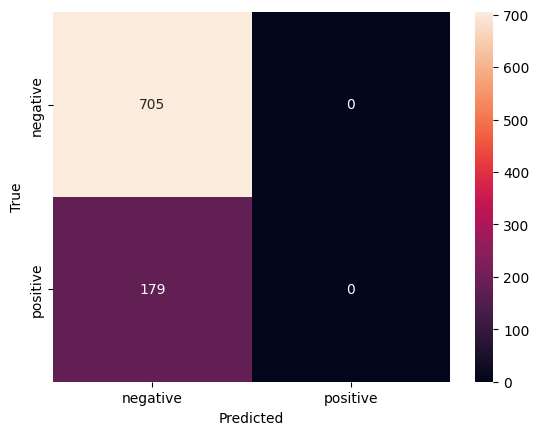

In [13]:
test_results = trainer.evaluate(tokenized_datasets["test"])
print("Test Metrics:", test_results)

# Confusion Matrix (for detailed analysis)

test_preds = trainer.predict(tokenized_datasets["test"])
preds = np.argmax(test_preds.predictions, axis=1)
cm = confusion_matrix(tokenized_datasets["test"]["labels"], preds)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")

In [14]:
from sklearn.metrics import classification_report

predictions = trainer.predict(tokenized_datasets["test"])
print(classification_report(predictions.label_ids, predictions.predictions.argmax(-1)))

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.80      1.00      0.89       705
           1       0.00      0.00      0.00       179

    accuracy                           0.80       884
   macro avg       0.40      0.50      0.44       884
weighted avg       0.64      0.80      0.71       884



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Text(0.5, 1.0, 'Prompt Tuning Loss Curve')

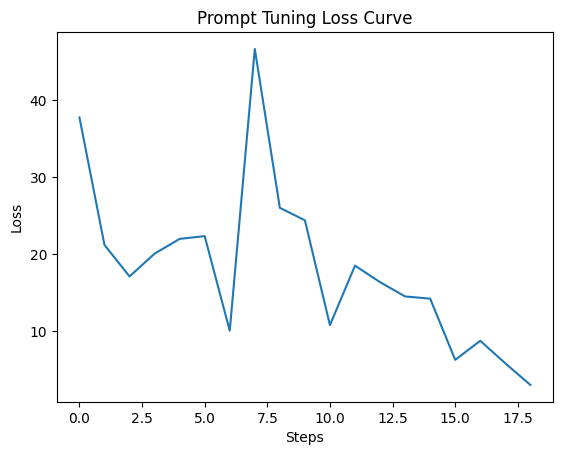

In [15]:
logs = trainer.state.log_history
plt.plot([log["loss"] for log in logs if "loss" in log])
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Prompt Tuning Loss Curve")

In [16]:
model.print_trainable_parameters()

trainable params: 1,061,890 || all params: 560,954,372 || trainable%: 0.1893
